In [1]:
!pip3 install tqdm

  Using cached https://files.pythonhosted.org/packages/4a/1c/6359be64e8301b84160f6f6f7936bbfaaa5e9a4eab6cbc681db07600b949/tqdm-4.45.0-py2.py3-none-any.whl


In [2]:
import torch
from torch import nn, functional as F
import numpy as np
from matplotlib import pyplot as plt
from torch.optim import Adam, SGD
from tqdm import tqdm

import matplotlib.colors as colors

import warnings
warnings.filterwarnings('ignore')

from customClasses import LinearNet, LinearHettingerInit, CReLU
from datahandler import constructLoader

In [3]:
# initialize train and testloaders
# set options and train
ds_name = 'cos'
#ds_name = 'check'
datasetLength = 1000
test_size = .33

if ds_name == 'cos':
    loss = 'mean_squared_error'
    lossf = nn.MSELoss()
    outf = None

elif ds_name == 'check':
    lossf = nn.CrossEntropyLoss()
    outf = nn.Sigmoid()

trainloader, testloader = constructLoader(ds_name, m=datasetLength, test_size=test_size, random_state=42, train_batch_size=128, test_batch_size=32)

In [4]:
outf = None
inDim = 1
outDim = 1
depth = 5
width = 20

LinearCH = LinearNet(inDim, outDim, depth, width, layerClass=LinearHettingerInit, activationClass=CReLU, outf=outf)
LinearC = LinearNet(inDim, outDim, depth, width, layerClass=nn.Linear, activationClass=CReLU, outf=outf)

In [5]:
def train(network, train_loader, test_loader, optimizer, loss_func,
          num_classes,
          losses_train=[], losses_test=[], 
          weight=None, epochs=10, batch_size=500,
          graph_skip=50, tqdm_bool=True, plot_every=None):
    """
    input parameters:
        network: The network used to train.

        losses_train: the array where averaged training losses are stored. 
          If this is to be kept over multiple calls to train_heartbeat than should be passed in.
        losses_test: the array where testing losses are stored. " "

        lr: the learning rate given to the Adam optimizer
        betas: the betas parameter given to the Adam optimizer

        weight: the weight parameter passed to the Cross Entropy Loss function.
          This is used when highly unbalanced classes are present in the training data

        epochs: the number of epochs to train over
        batch_size: the batch size for both training and testing

        graph_skip: the number of batches to complete before storing the losses
        tqdm_bool: whether or not to display a progress bar
        plot_every: the number of epochs to complete in between plotting losses and accuracy measurements
          if None will never plot

        num_classes: used in plotting devices. Could find a way not to need this as parameter.

       return values:

    """ 

    # save the data transform intended for use with the given network and move the network to gpu
    network = network.cuda()

    # begin training loop
    for epoch in range(1,epochs+1):

        if tqdm_bool:
            loop = tqdm(total = len(train_loader), position=0)
            loop.set_description('epoch: {:1d}'.format(epoch))

        # initialize temporary training losses array. This will be averaged and reset each i%graph_skip==0 iteration
        temp_losses_train = []

        for i, (x_train, y_train) in enumerate(train_loader):
            x_train, y_train = x_train.cuda(async=True), y_train.cuda(async=True)

            # zero gradients
            optimizer.zero_grad()

            # calculate and store training loss
            y_train_hat = network(x_train)
            loss_train = loss_func(y_train_hat, y_train)

            # call .backward and step
            loss_train.backward()
            print(loss_train)
            optimizer.step()

            # store loss, accuracy, and per class accuracies calling .cpu on each
            temp_losses_train.append(loss_train.detach().cpu().item())


            #calculate testing loss, and store training and testing losses for later plotting every (graph_skip)th iteration
            if i > 0 and i%graph_skip==0:
                # store averaged accuracies and training loss and update progress bar
                # also reset temporary arrays
                lt = np.mean(temp_losses_train)
                losses_train.append(lt)
                temp_losses_train = []


                if tqdm_bool:
                    loop.set_description('epoch: {:1d}, averaged loss: {:.3f}'
                                       .format(epoch, lt))

                with torch.no_grad():
                    #get x and y test and transfer them to gpu
                    x_test, y_test = next(iter(test_loader))
                    x_test, y_test = x_test.cuda(async=True), y_test.cuda(async=True) #async tiny speed improvement

                    # calculate and store testing losses
                    y_test_hat = network(x_test)
                    loss_test = loss_func(y_test_hat,y_test).detach().cpu()
                    losses_test.append(loss_test)

            #update progress bar
            if tqdm_bool:
                loop.update(1)

        # close progress bar for this epoch
        if tqdm_bool:
            loop.close()

        if plot_every is not None:
            if epoch%plot_every==0:    
                x_spacing = np.arange(len(losses_train))
                plt.plot(graph_skip*x_spacing, losses_train, label='Training loss')
                plt.plot(graph_skip*x_spacing, losses_test, label='Testing loss')
                plt.xlabel('iterations')
                plt.ylabel('loss')
                plt.title("Loss over time")
                plt.legend()
                plt.show()

In [7]:
outf = None
inDim = 2
outDim = 1
depth = 5
width = 20

LinearCH = LinearNet(inDim, outDim, depth, width, layerClass=LinearHettingerInit, activationClass=CReLU, outf=outf)

optimizer = torch.optim.Adam(LinearCH.parameters())

train(LinearCH, trainloader, testloader, optimizer, lossf, 1,
          losses_train=[], losses_test=[], 
          weight=None, epochs=10, batch_size=1,
          graph_skip=1, tqdm_bool=True, plot_every=10)

epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 136.91it/s]


tensor(0.8055, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.4381, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.2723, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.2496, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.2579, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.2433, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.2029, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.1510, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.1052, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0746, device='cuda:0', grad_fn=<MseLossBackward>)


epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 136.27it/s]


tensor(0.0604, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0385, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>)


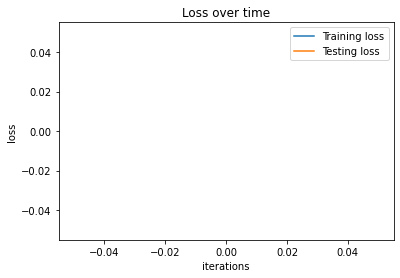

In [8]:
outf = None
inDim = 2
outDim = 1
depth = 5
width = 20

LinearC = LinearNet(inDim, outDim, depth, width, layerClass=nn.Linear, activationClass=CReLU, outf=outf)

optimizer = torch.optim.Adam(LinearCH.parameters())

train(LinearCH, trainloader, testloader, optimizer, lossf, 1,
          losses_train=[], losses_test=[], 
          weight=None, epochs=10, batch_size=1,
          graph_skip=1, tqdm_bool=True, plot_every=10)

In [ ]:
print(len(trainloader))

In [ ]:
for x, y in trainloader:
    print(x, y)